In [2]:
import scipy.io
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.callbacks import  EarlyStopping
import random
import os

# 기존 train 데이터 불러오기
# [11, 505000, 2]
train_sub_data = scipy.io.loadmat('../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']

# 퍼블릭 데이터 불러오기
# [109, 9600, 2]
public_data = scipy.io.loadmat('../datas/160hz/Motor_Imagery.mat', squeeze_me=True)['data']

# 기존 test 데이터 불러오기
# [11, 101402, 2]
test_sub_data = scipy.io.loadmat('../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# # 데이터를 480(= 160*3) 크기로 사용할 수 있도록 그 배수로 전체 데이터 잘라줌
data_cut_size = 504960 # 480*1052 = 504960
public_cut_size = 9600 # 480*20 = 9600
test_cut_size = 101280 # 480*211 = 101280

# 트레인 sub 수
train_sub_cnt = train_sub_data.shape[0]
# 퍼블릭 데이터 sub 수
public_sub_cnt = public_data.shape[0]
# test 데이터 sub 수
test_sub_cnt = test_sub_data.shape[0]

sub_cnt = train_sub_cnt + public_sub_cnt

train_sub_cut = train_sub_data[:, 0:data_cut_size, :]
public_data_cut = public_data[:, 0:public_cut_size, :]
test_sub_cut = test_sub_data[:, 0:test_cut_size, :]

print(train_sub_cut.shape)
print(test_sub_cut.shape)
print(public_data_cut.shape)

# 데이터를 스케일링 하기 위해 2D로 reshape
train_sub_2D = train_sub_cut.reshape(-1, 1)
public_data_2D = public_data_cut.reshape(-1, 1)
test_2D = test_sub_cut.reshape(-1, 1)

# 데이터를 StandardScaler로 스케일링
# 데이터들 모두 같은 방식으로 스케일링함
SDscaler = StandardScaler()
SDscaler.fit(train_sub_2D)
train_scaled = SDscaler.transform(train_sub_2D)
test_scaled = SDscaler.transform(test_2D)
public_scaled = SDscaler.transform(public_data_2D)

# 데이터 크기를 480로 맞춰줌
# 5554560/480 = 115,72
data_size = 480
train_sub_size = 1052 # 1명당 3초 데이터 1052개
public_sub_size = 20
test_sub_size = 211

train_data = train_scaled.reshape(train_sub_cnt * train_sub_size, data_size, 2)
public_data = public_scaled.reshape(public_sub_cnt * public_sub_size, data_size, 2)
test_data = test_scaled.reshape(test_sub_cnt * test_sub_size, data_size, 2)

print(train_data.shape)
print(public_data.shape)
print(test_data.shape)

#test data를 sub:other=1:1로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(test_sub_cnt):
    test_data_each.insert(i, test_data[i*test_sub_size:(i+1)*test_sub_size, :, :])
# print(test_data_each)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(train_sub_cnt):
    train_data_each.insert(i, train_data[i*train_sub_size:(i+1)*train_sub_size, :, :])
    
public_data_each = []
for i in range(public_sub_cnt):
    public_data_each.insert(i, public_data[i*public_sub_size:(i+1)*public_sub_size, :, :])
    
print(len(train_data_each))
print(len(public_data_each))
print(len(test_data_each))

(11, 504960, 2)
(11, 101280, 2)
(109, 9600, 2)
(11572, 480, 2)
(2180, 480, 2)
(2321, 480, 2)
11
109
11


In [3]:
# 평가 지표
test_pre_all = []
conf_mat_all = []
test_loss_all = []
test_acc_all = []
test_sen_all = []
test_spe_all = []
test_precision_all = []
frr_all = []
far_all = []

In [4]:
dir_name = './model/'
os.makedirs(dir_name, exist_ok = True)          # Creating a directory

[[[ -0.59274488  -0.11557774]
  [  0.84180354   0.74014046]
  [  0.76952622   0.67580079]
  ...
  [ -1.39409631  -1.41150237]
  [ -0.40536749  -0.27357772]
  [ -0.12389917   0.01764349]]

 [[ -0.23883712  -0.3277522 ]
  [ -0.65945725  -0.76386399]
  [ -1.39447881  -1.23478541]
  ...
  [-14.32110485 -15.84968554]
  [ -7.01974489  -8.42695906]
  [  5.03146122   2.6364256 ]]

 [[ 10.44428078   7.54193394]
  [  5.69399596   3.97099817]
  [ -1.6966704   -1.5576007 ]
  ...
  [ -0.06469137  -0.14895026]
  [  1.02499596   0.86776294]
  [  1.30976889   1.23667153]]

 ...

 [[  0.90510202   0.61615841]
  [  1.68917012   1.48918788]
  [  1.5999366    1.67733039]
  ...
  [ -1.06470772  -0.85172081]
  [ -0.04670922  -0.36988642]
  [  0.51734405  -0.21347719]]

 [[  0.05280134   0.07274614]
  [ -0.13054871   0.7905272 ]
  [  0.64001279   1.21190913]
  ...
  [ -0.01829107  -0.49488431]
  [ -0.32333638  -0.48588363]
  [ -0.23247333  -0.2411579 ]]

 [[  0.10603142  -0.16025577]
  [  0.12334795  -0.2583

211/211 [==============================] - 2s 10ms/step - loss: 0.0462 - accuracy: 0.9820
Epoch 51/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0290 - accuracy: 0.9878
Epoch 52/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0317 - accuracy: 0.9877
Epoch 53/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0456 - accuracy: 0.9836
Epoch 54/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0383 - accuracy: 0.9882
Epoch 55/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0538 - accuracy: 0.9824
Epoch 56/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0508 - accuracy: 0.9787
Epoch 57/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0548 - accuracy: 0.9808
Epoch 58/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0334 - accuracy: 0.9891
Epoch 59/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0377 - 

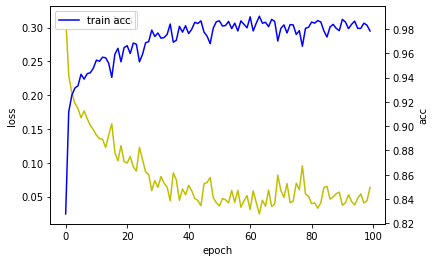

27/27 - 1s - loss: 0.3528 - accuracy: 0.8922
[[571  62]
 [ 29 182]]

 [633 211]
sensitivity :  0.8625592417061612
specificity :  0.9020537124802528
frr :  0.13744075829383887
far :  0.09794628751974724


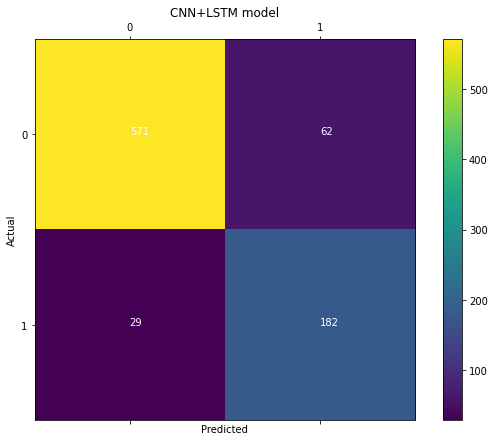

(4208, 480, 2)
(844, 480, 2)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 480, 2)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 480, 16)           112       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 160, 16)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 160, 32)           1568      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 53, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 53, 64)            6208      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (

211/211 [==============================] - 2s 10ms/step - loss: 0.0308 - accuracy: 0.9867
Epoch 62/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0254 - accuracy: 0.9873
Epoch 63/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0283 - accuracy: 0.9912
Epoch 64/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0711 - accuracy: 0.9722
Epoch 65/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0225 - accuracy: 0.9919
Epoch 66/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0320 - accuracy: 0.9889
Epoch 67/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0251 - accuracy: 0.9909
Epoch 68/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0401 - accuracy: 0.9846
Epoch 69/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0331 - accuracy: 0.9911
Epoch 70/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0193 - 

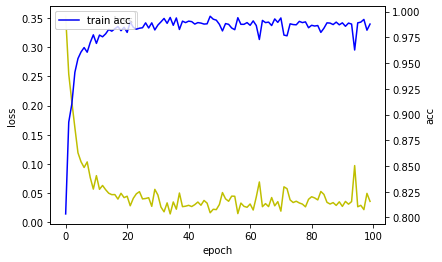

27/27 - 0s - loss: 0.4037 - accuracy: 0.8993
[[562  71]
 [ 14 197]]

 [633 211]
sensitivity :  0.933649289099526
specificity :  0.8878357030015798
frr :  0.06635071090047394
far :  0.11216429699842022


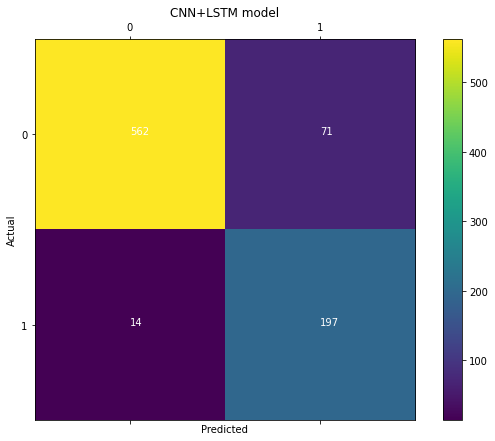

(4208, 480, 2)
(844, 480, 2)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 480, 2)]          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 480, 16)           112       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 160, 16)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 160, 32)           1568      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 53, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 53, 64)            6208      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (

211/211 [==============================] - 2s 9ms/step - loss: 0.0127 - accuracy: 0.9960
Epoch 62/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0173 - accuracy: 0.9952
Epoch 63/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0331 - accuracy: 0.9884
Epoch 64/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0137 - accuracy: 0.9930
Epoch 65/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0175 - accuracy: 0.9928
Epoch 66/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0555 - accuracy: 0.9767
Epoch 67/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0145 - accuracy: 0.9956
Epoch 68/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0297 - accuracy: 0.9908
Epoch 69/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0280 - accuracy: 0.9906
Epoch 70/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0419 - accuracy:

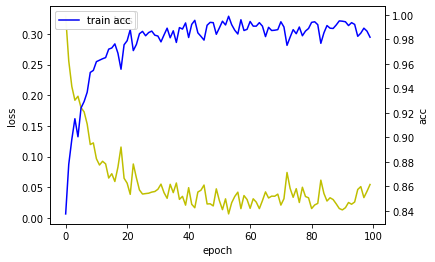

27/27 - 1s - loss: 0.3419 - accuracy: 0.8886
[[552  81]
 [ 13 198]]

 [633 211]
sensitivity :  0.9383886255924171
specificity :  0.8720379146919431
frr :  0.061611374407582936
far :  0.12796208530805686


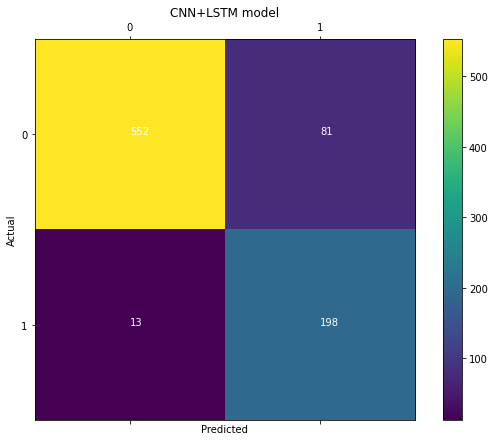

(4208, 480, 2)
(844, 480, 2)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 480, 2)]          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 480, 16)           112       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 160, 16)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 160, 32)           1568      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 53, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 53, 64)            6208      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (

211/211 [==============================] - 2s 9ms/step - loss: 0.0221 - accuracy: 0.9924
Epoch 62/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0431 - accuracy: 0.9815
Epoch 63/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0188 - accuracy: 0.9954
Epoch 64/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0311 - accuracy: 0.9905
Epoch 65/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0259 - accuracy: 0.9919
Epoch 66/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0335 - accuracy: 0.9880
Epoch 67/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0147 - accuracy: 0.9978
Epoch 68/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0413 - accuracy: 0.9864
Epoch 69/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0114 - accuracy: 0.9976
Epoch 70/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0394 - accuracy: 

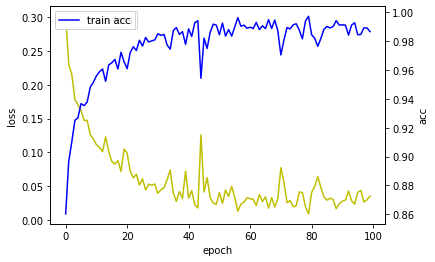

27/27 - 0s - loss: 0.3973 - accuracy: 0.9017
[[563  70]
 [ 13 198]]

 [633 211]
sensitivity :  0.9383886255924171
specificity :  0.8894154818325435
frr :  0.061611374407582936
far :  0.11058451816745656


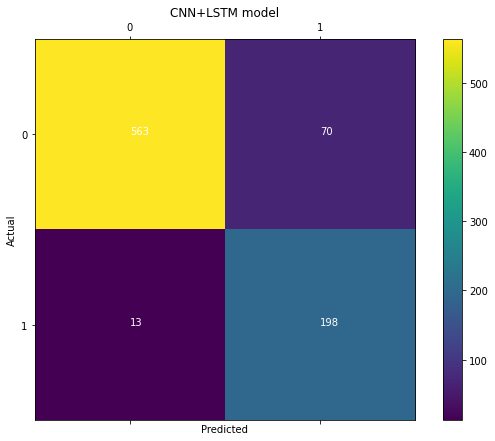

(4208, 480, 2)
(844, 480, 2)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 480, 2)]          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 480, 16)           112       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 160, 16)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 160, 32)           1568      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 53, 32)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 53, 64)            6208      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (

211/211 [==============================] - 2s 9ms/step - loss: 0.0269 - accuracy: 0.9910
Epoch 62/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0336 - accuracy: 0.9904
Epoch 63/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0259 - accuracy: 0.9894
Epoch 64/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0368 - accuracy: 0.9860
Epoch 65/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0206 - accuracy: 0.9921
Epoch 66/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0500 - accuracy: 0.9861
Epoch 67/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0783 - accuracy: 0.9695
Epoch 68/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0268 - accuracy: 0.9903
Epoch 69/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0144 - accuracy: 0.9944
Epoch 70/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0492 - accuracy: 

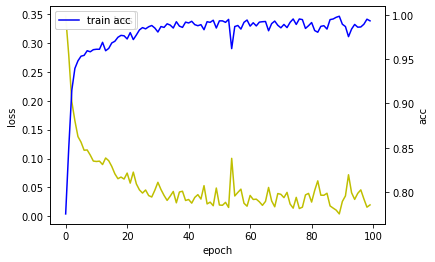

27/27 - 0s - loss: 0.5916 - accuracy: 0.8886
[[598  35]
 [ 59 152]]

 [633 211]
sensitivity :  0.7203791469194313
specificity :  0.9447077409162717
frr :  0.2796208530805687
far :  0.05529225908372828


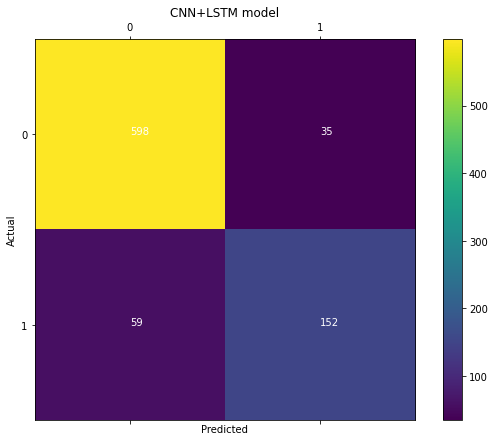

(4208, 480, 2)
(844, 480, 2)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 480, 2)]          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 480, 16)           112       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 160, 16)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 160, 32)           1568      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 53, 32)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 53, 64)            6208      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (

211/211 [==============================] - 2s 9ms/step - loss: 0.0227 - accuracy: 0.9915
Epoch 62/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0246 - accuracy: 0.9921
Epoch 63/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0428 - accuracy: 0.9871
Epoch 64/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0402 - accuracy: 0.9846
Epoch 65/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0209 - accuracy: 0.9926
Epoch 66/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0119 - accuracy: 0.9970
Epoch 67/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0719 - accuracy: 0.9763
Epoch 68/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0187 - accuracy: 0.9939
Epoch 69/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0355 - accuracy: 0.9887
Epoch 70/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0263 - accurac

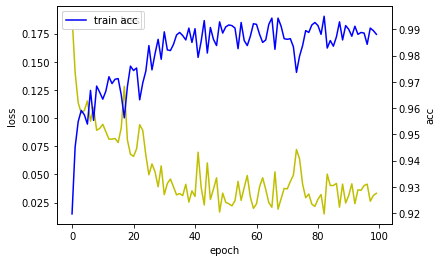

27/27 - 0s - loss: 0.1589 - accuracy: 0.9538
[[608  25]
 [ 14 197]]

 [633 211]
sensitivity :  0.933649289099526
specificity :  0.9605055292259084
frr :  0.06635071090047394
far :  0.03949447077409163


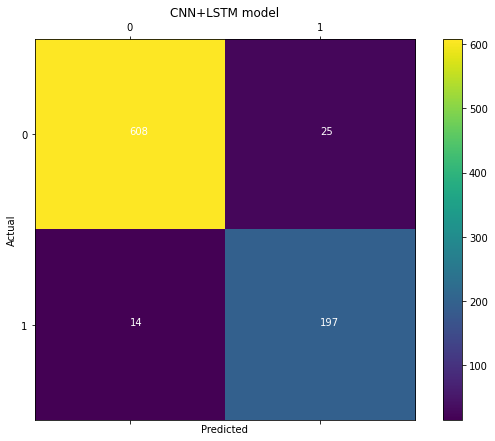

(4208, 480, 2)
(844, 480, 2)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 480, 2)]          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 480, 16)           112       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 160, 16)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 160, 32)           1568      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 53, 32)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 53, 64)            6208      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (

211/211 [==============================] - 2s 9ms/step - loss: 0.0455 - accuracy: 0.9838
Epoch 62/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0721 - accuracy: 0.9751
Epoch 63/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0390 - accuracy: 0.9844
Epoch 64/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0421 - accuracy: 0.9873
Epoch 65/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0436 - accuracy: 0.9849
Epoch 66/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0458 - accuracy: 0.9829
Epoch 67/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0892 - accuracy: 0.9691
Epoch 68/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0633 - accuracy: 0.9779
Epoch 69/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0309 - accuracy: 0.9883
Epoch 70/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0681 - accura

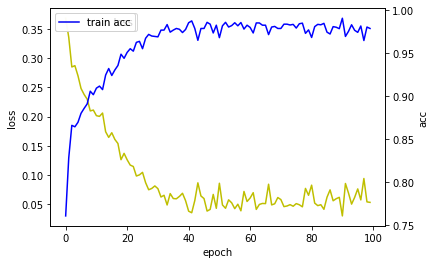

27/27 - 0s - loss: 0.7652 - accuracy: 0.7192
[[467 166]
 [ 71 140]]

 [633 211]
sensitivity :  0.6635071090047393
specificity :  0.7377567140600316
frr :  0.33649289099526064
far :  0.26224328593996843


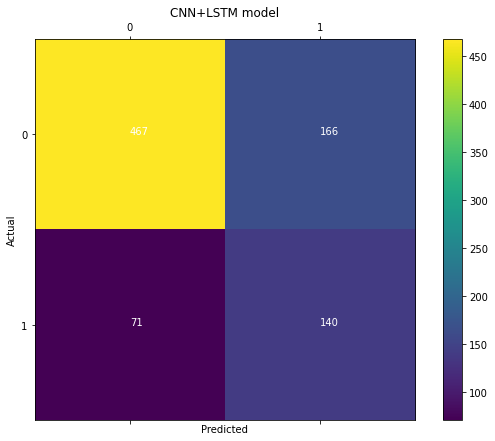

(4208, 480, 2)
(844, 480, 2)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 480, 2)]          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 480, 16)           112       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 160, 16)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 160, 32)           1568      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 53, 32)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 53, 64)            6208      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (

211/211 [==============================] - 2s 9ms/step - loss: 0.0371 - accuracy: 0.9891
Epoch 62/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0203 - accuracy: 0.9934
Epoch 63/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0077 - accuracy: 0.9973
Epoch 64/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0631 - accuracy: 0.9762
Epoch 65/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0415 - accuracy: 0.9821
Epoch 66/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0338 - accuracy: 0.9880
Epoch 67/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0220 - accuracy: 0.9930
Epoch 68/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0531 - accuracy: 0.9782
Epoch 69/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0435 - accuracy: 0.9840
Epoch 70/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0349 - accuracy: 

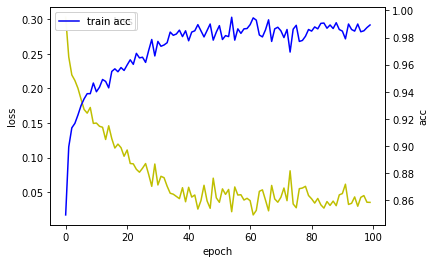

27/27 - 0s - loss: 0.8958 - accuracy: 0.7844
[[487 146]
 [ 36 175]]

 [633 211]
sensitivity :  0.8293838862559242
specificity :  0.7693522906793049
frr :  0.17061611374407584
far :  0.23064770932069512


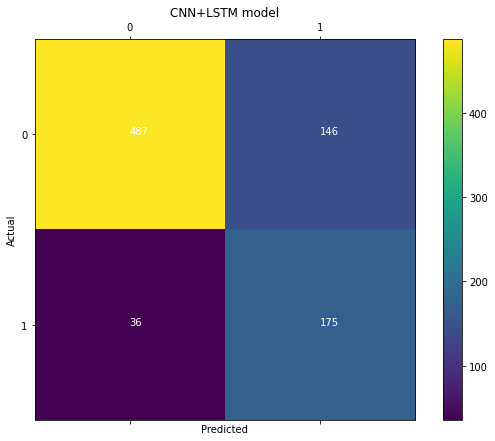

(4208, 480, 2)
(844, 480, 2)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 480, 2)]          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 480, 16)           112       
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 160, 16)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 160, 32)           1568      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 53, 32)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 53, 64)            6208      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (

211/211 [==============================] - 2s 10ms/step - loss: 0.0320 - accuracy: 0.9903
Epoch 62/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0408 - accuracy: 0.9833
Epoch 63/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0360 - accuracy: 0.9875
Epoch 64/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0278 - accuracy: 0.9890
Epoch 65/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0208 - accuracy: 0.9951
Epoch 66/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0119 - accuracy: 0.9966
Epoch 67/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0871 - accuracy: 0.9716
Epoch 68/100
211/211 [==============================] - 2s 9ms/step - loss: 0.1085 - accuracy: 0.9622
Epoch 69/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0576 - accuracy: 0.9837
Epoch 70/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0517 - accuracy:

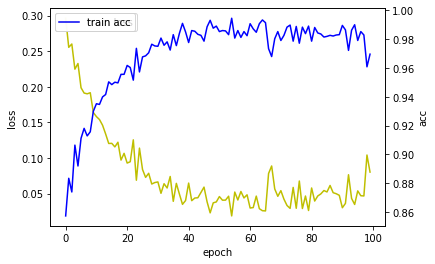

27/27 - 1s - loss: 0.2945 - accuracy: 0.9052
[[567  66]
 [ 14 197]]

 [633 211]
sensitivity :  0.933649289099526
specificity :  0.8957345971563981
frr :  0.06635071090047394
far :  0.10426540284360189


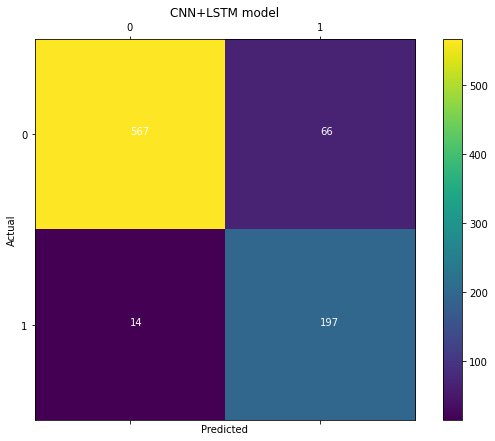

(4208, 480, 2)
(844, 480, 2)
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 480, 2)]          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 480, 16)           112       
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 160, 16)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 160, 32)           1568      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 53, 32)            0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 53, 64)            6208      
_________________________________________________________________
max_pooling1d_32 (MaxPooling 

211/211 [==============================] - 2s 9ms/step - loss: 0.0051 - accuracy: 0.9983
Epoch 62/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0197 - accuracy: 0.9964
Epoch 63/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0025 - accuracy: 0.9999
Epoch 64/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0044 - accuracy: 0.9982
Epoch 65/100
211/211 [==============================] - 2s 9ms/step - loss: 2.5599e-04 - accuracy: 1.0000
Epoch 66/100
211/211 [==============================] - 2s 9ms/step - loss: 4.2550e-05 - accuracy: 1.0000
Epoch 67/100
211/211 [==============================] - 2s 9ms/step - loss: 1.2714e-05 - accuracy: 1.0000
Epoch 68/100
211/211 [==============================] - 2s 9ms/step - loss: 1.0111e-05 - accuracy: 1.0000
Epoch 69/100
211/211 [==============================] - 2s 9ms/step - loss: 1.2820e-04 - accuracy: 1.0000
Epoch 70/100
211/211 [==============================] - 2s 9ms/step - loss:

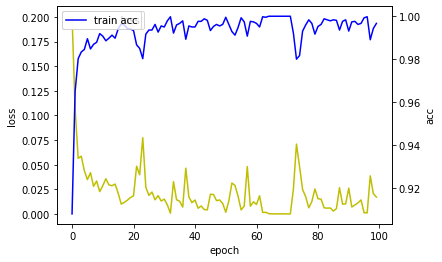

27/27 - 0s - loss: 0.0693 - accuracy: 0.9692
[[625   8]
 [ 18 193]]

 [633 211]
sensitivity :  0.9146919431279621
specificity :  0.9873617693522907
frr :  0.08530805687203792
far :  0.01263823064770932


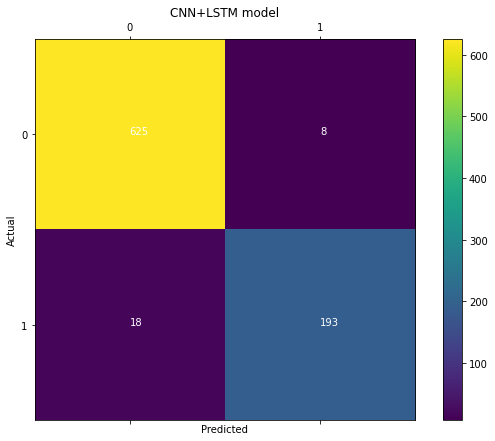

(4208, 480, 2)
(844, 480, 2)
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 480, 2)]          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 480, 16)           112       
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 160, 16)           0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 160, 32)           1568      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 53, 32)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 53, 64)            6208      
_________________________________________________________________
max_pooling1d_35 (MaxPooling 

211/211 [==============================] - 2s 9ms/step - loss: 0.0404 - accuracy: 0.9858
Epoch 62/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0291 - accuracy: 0.9908
Epoch 63/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0332 - accuracy: 0.9873
Epoch 64/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0449 - accuracy: 0.9852
Epoch 65/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0355 - accuracy: 0.9890
Epoch 66/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0395 - accuracy: 0.9844
Epoch 67/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0358 - accuracy: 0.9900
Epoch 68/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0285 - accuracy: 0.9912
Epoch 69/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0363 - accuracy: 0.9868
Epoch 70/100
211/211 [==============================] - 2s 9ms/step - loss: 0.0384 - accuracy: 

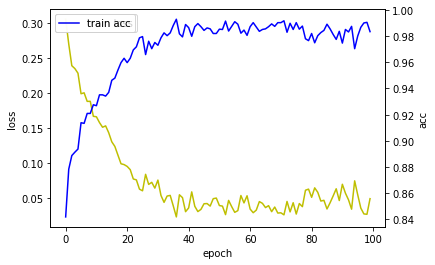

27/27 - 0s - loss: 0.2958 - accuracy: 0.9040
[[576  57]
 [ 24 187]]

 [633 211]
sensitivity :  0.8862559241706162
specificity :  0.909952606635071
frr :  0.11374407582938388
far :  0.09004739336492891


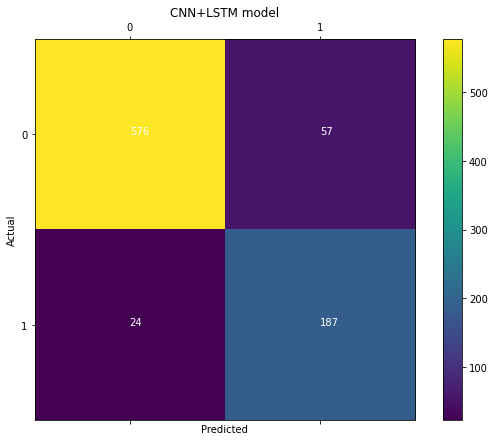

average_accuracy
0.8823782801628113
average_sensitivity
0.8685911245152951
average_specificity
0.8869740054574179
average_frr
0.1314088754847049
average_far
0.11302599454258222


In [6]:
# cnt = 3


# for num in range(cnt):
# 각 sub 마다 모델 학습

# train data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 1052 : 3156
# 26 * 57 + 27 * 62 = 3156  ###########################안 됨 public data 20개씩 있음.
# => 97 * 4 + 98 * 6 + 20 * 109 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

for i in range(train_sub_cnt):
    cnt = 0
    train_data_n = train_data_each[i]
    test_data_n = test_data_each[i]
    
    if (i == 0):
        print(test_data_n)

    for j in range(train_sub_cnt):
        if j != i and cnt < 4:
            cnt = cnt + 1
            train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 97)), axis = 0)
        elif j != i and cnt >= 4:
            train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 98)), axis = 0)

    for j in range(public_sub_cnt):
        train_data_n = np.append(train_data_n, np.array(random.sample(list(public_data_each[j]), 20)), axis = 0)

    cnt = 0

    for j in range(test_sub_cnt):
        if j != i and cnt < 7:
            cnt = cnt + 1
            test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
        elif j != i and cnt >= 7:
            test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)

    print(train_data_n.shape)
    print(test_data_n.shape)

    train_label = np.zeros(train_sub_size*4)
    test_label = np.zeros(test_sub_size*4)

    for j in range(len(train_label)):
        if (j < train_sub_size):
            train_label[j] = 1

    for j in range(len(test_label)):
        if (j < test_sub_size):
            test_label[j] = 1

    ################################################################
    # 모델 구성하기                                                #
    # 이진 분류이기 때문에 0~1 사이의 값을 나타내는 출력뉴런 1개   #
    ################################################################

    # Cnn 층
    inputs = tf.keras.Input(shape = (480, 2))

    layers = tf.keras.layers.Conv1D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', activation  = 'relu')(inputs)
    layers = tf.keras.layers.MaxPool1D(3)(layers)

    layers = tf.keras.layers.Conv1D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation  = 'relu')(layers)
    layers = tf.keras.layers.MaxPool1D(3)(layers)

    layers = tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(layers)
    layers = tf.keras.layers.MaxPool1D(3)(layers)

    # LSTM 층
    layers = tf.keras.layers.LSTM(64)(layers)

    # Dense 층
    layers = tf.keras.layers.Dropout(0.3)(layers)
    layers = tf.keras.layers.Dense(128, activation='relu')(layers)
    # layers = tf.keras.layers.Dropout(0.01)(layers)
    layers = tf.keras.layers.Dense(64, activation='relu')(layers)
    # layers = tf.keras.layers.Dropout(0.05)(layers)
    layers = tf.keras.layers.Dense(1, activation='sigmoid')(layers)

    model = tf.keras.models.Model(inputs = inputs, outputs = layers)
    model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.Adam(0.005), metrics=['accuracy'])
    model.summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(patience= 20)

    # train 데이터를 train과 validation으로 분배
    # validation 데이터를 여러 sub에서 가져갈 수 있도록 shuffle
    # x_train, x_val, y_train, y_val = train_test_split(train_data, train_label, test_size=0.1, shuffle=True, random_state=1)

    print('##########')
    print('# sub', i+1, ' #')
    print('##########')

    # 모델 돌리기
#     hist = model.fit(x_train, y_train, batch_size=40, epochs=200, validation_data=(x_val, y_val), verbose=1, callbacks= [early_stopping])
    hist = model.fit(train_data_n, train_label, batch_size=20, epochs=100, verbose=1)

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')


    acc_ax.plot(hist.history['accuracy'], 'b', label = 'train acc')
    acc_ax.set_ylabel('acc')
    acc_ax.legend(loc='upper left')

    plt.show()

    if i < 10 :
        model_name = 'model/Sub_Model_0'+str(i+1)+'.h5'
    else :
        model_name = 'model/Sub_Model_'+str(i+1)+'.h5'

    # save model
    model.save(model_name)

    test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose= 2)
    test_pred = model.predict(test_data_n)

    test_loss_all.append(test_loss)
    test_acc_all.append(test_acc)

    # 확률이 0.5이상이면 자신(1), 작으면 타인(0)
    for i in range(len(test_pred)):
        if(0.5 <= test_pred[i]):
            test_pred[i] = 1

        else:
            test_pred[i] = 0


    test_pre_all.append(test_pred)

    # confusion matrix 생성
    conf_matrix = confusion_matrix(test_label, test_pred)

    #############################################################
    #       conf_matrix[0][0] = TN      conf_matrix[0][1] = FP  #
    #       conf_matrix[1][0] = FN      conf_matrix[1][1] = TP  #
    #############################################################

    print(conf_matrix)
    conf_mat_all.append(conf_matrix)

    # sum 이용 각 행 더하기
    row = conf_matrix.sum(axis=1)
    print('\n', row)

    # row[0] = spec의 분모, row[1] = sens의 분모

    test_sensitivity = conf_matrix[1][1] / row[1]
    test_specificity = conf_matrix[0][0] / row[0]

    test_frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
    test_far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
        
    test_precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
    test_precision_all.append(test_precision)

    print('sensitivity : ', test_sensitivity)
    print('specificity : ', test_specificity) 
    print('frr : ', test_frr)
    print('far : ', test_far) 

    test_sen_all.append(test_sensitivity)
    test_spe_all.append(test_specificity)
    frr_all.append(test_frr)
    far_all.append(test_far)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    cax = ax.matshow(conf_matrix)

    fig.colorbar(cax)

    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, conf_matrix[i, j], color="white")

    plt.title('CNN+LSTM model')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.show()

print('average_accuracy')
print(np.mean(test_acc_all))
print('average_sensitivity')
print(np.mean(test_sen_all))
print('average_specificity')
print(np.mean(test_spe_all))
print('average_frr')
print(np.mean(frr_all))
print('average_far')
print(np.mean(far_all))

In [ ]:
test_pre_all_o = test_pre_all
conf_mat_all_o = conf_mat_all
test_loss_all_o = test_loss_all
test_acc_all_o = test_acc_all
test_sen_all_o = test_sen_all
test_spe_all_o = test_spe_all
test_precision_all_o = test_precision_all

predict = np.array(test_pre_all_o, dtype=np.int8)
print(predict.shape[0])
print(predict.shape[1])
print(predict.shape[2])
predict = predict.reshape(11, 422).T

conf_mat = np.array(conf_mat_all_o)

loss = np.array(test_loss_all_o)

acc = np.array(test_acc_all_o)
sen = np.array(test_sen_all_o)
spe = np.array(test_spe_all_o)
pre = np.array(test_precision_all_o)

import pandas as pd

# Create a Pandas Excel writer
writer = pd.ExcelWriter('Result.xlsx')

# Test_Predict
df_predict = pd.DataFrame([])

# Confusion_Matrix
# conf_mat의 엑셀에서 위치 저장할 변수
conf_row = 1
conf_col = 0

# 포문쓰기
for i in range(test_sub_cnt):
#     columns = list("01")
#     columns = list(zip(['Sub_' + str(i+1)] * 2, columns))
#     columns = pd.MultiIndex.from_tuples(columns)  
    df_conf = pd.DataFrame(conf_mat[i], index=['Other', 'Sub'], columns=[['Sub_' + str(i+1)] * 2, ['Negative', 'Positive']])
#     df_conf = pd.DataFrame(conf_mat[i], index=['Other', 'Sub'], columns=['a', 'b'])
#     df_conf.columns = pd.MultiIndex.from_tuples(zip(['Sub_' + str(i+1)] * 2, df_conf.columns)) 
#     df_conf.index = ['Other', 'Sub']
#     df_conf.columns = pd.MultiIndex.from_product([['Sub_' + str(i+1)],'0'])
    df_conf.to_excel(writer, sheet_name='Conf_Mat', startrow=conf_row, startcol=conf_col)
    conf_col += 4
    if i == 2:
        conf_row += 6
        conf_col = 0
    elif i == 5:
        conf_row += 6
        conf_col = 0
    elif i == 8:
        conf_row += 6
        conf_col = 0


# Test_Loss
df_loss = pd.DataFrame(loss)
df_loss = df_loss.transpose()

# Test_Accuracy
df_acc = pd.DataFrame(acc)
df_acc = df_acc.transpose()

# Test_Sensitivitiy
df_sen = pd.DataFrame(sen)
df_sen = df_sen.transpose()

# Test_Specificity
df_spe = pd.DataFrame(spe)
df_spe = df_spe.transpose()

# Test_Precision
df_pre = pd.DataFrame(pre)
df_pre = df_pre.transpose()

# Test_Predict 값 채우기
for i in range(test_sub_cnt) :
    column = ('Predict_' + str(i + 1))
    df_predict[column] = predict[:, i]
    
# 칼럼 배열 ['Sub_1', 'Sub_2', ...]
col = []
for i in range(test_sub_cnt) :
    column = ('Sub_' + str(i + 1))
    col.append(column)
col = np.array(col)

# 각 데이터 프레임의 칼럼과 인덱스 설정
df_loss.columns = col
df_loss.index = ['Test_Loss']
df_acc.index = ['Test_Accuracy']
df_sen.columns = col
df_sen.index = ['Test_Sensitivity']
df_spe.index = ['Test_Speicificity']
df_pre.columns = col
df_pre.index = ['Test_Presicion']

# 모든 데이터 프레임 저장

df_predict.to_excel(writer, sheet_name='Predict', index=False, startrow=1)
# df_conf.to_excel(writer, sheet_name='Conf_Mat')

# Result Sheet
row = 0
df_loss.to_excel(writer, sheet_name='Result', startrow = row)
row += df_loss.shape[0] + 1
df_acc.to_excel(writer, sheet_name='Result', header=None, startrow=row)
row += df_acc.shape[0] + 3
df_sen.to_excel(writer, sheet_name='Result', startrow=row)
row += df_sen.shape[0] + 1
df_spe.to_excel(writer, sheet_name='Result', header=None, startrow=row)
row += df_spe.shape[0] + 3
df_pre.to_excel(writer, sheet_name='Result', startrow=row)

# Close the Pandas Excel writer and output the Excel file.
writer.save()